In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

Your Name and PRN:
- Name : Tulsi Mundada
- PRN  : 240340128035
- Date : 36/04/2024

# Image Processing with Neural Network

## Assignment: A03
### Take Neural Network implementation with:
- One hidden layer 
- ${Tanh}$ activation function


### Assignment - Answer all Questions
- **Q1**: Is this model more accurate compared to previous model?
- **Q2**: Prepare table by changing number of neurons in hidden layer, learning rate and observe change in results. Also comment on your results.

|#|Dimension of hidden layer|Learning rate|Training Accuracy|Test Accuracy|Comment|
|:-:|:-:|:-:|:-:|:-:|:--|
|1|4|0.1|0.97|0.96|Base case||1|4|0.1|0.97|0.96|Base case|
|2|1|1|???|???|???|
|...|...|...|...|...|...|
|n|...|...|...|...|...|

- **Q3**: What lines will you change to convert it into multi-class prediction model?
- **Q4**: How many epochs are sufficient?

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections.abc import Callable
from typing import Literal

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

%matplotlib inline

In [3]:
###-----------------------
### Basic hyper-parameters
###-----------------------

inpDir = '../input' # set input path as per your system
outDir = '../output' # set output path as per your system

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.2
EPOCHS = 200  # number of epochs
ALPHA = 0.1  # learning rate
N_SAMPLES = 1000
TEST_SIZE =0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = 'coolwarm' # plt.cm.Spectral

plt.rcParams.update(params)

### Helper Functions

In [4]:
###-------------------------
### Function to plot history
###-------------------------

#### Note this function is specifically designed to plot Tensorflow training output

def fn_plot_hist(hist_df : pd.DataFrame):
    
    '''
    Args:
        hist_df: a dataframe with following columns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
    
    # create figure and axis array
    fig, axes = plt.subplots(1,2 , figsize = (15,6)) 

    
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)

    
    # take first axis
    ax = axes[0]
    
    
    # Plot Column 0 and 2 (Loss and validation loss)
    hist_df.plot(y = [hist_df.columns[0],hist_df.columns[2]], 
                 ax = ax,
                 colormap=CMAP) 

    # get minimum values for plotting
    lossmin = hist_df[hist_df.columns[0]].min()
    
    testmin = hist_df[hist_df.columns[2]].min()

    
    # little beautification
    txtstr = "Min {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[0],
                                                                          lossmin,
                                                                          testmin) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.4, 0.95, txtstr,
            transform=ax.transAxes,
            fontsize=14,
            verticalalignment='top',
            bbox=props)

    # x axis label
    ax.set_xlabel("Epochs")

    # y axis lable
    ax.set_ylabel(hist_df.columns[0].capitalize())
    
    # Show grids on the axis
    ax.grid()
    
    
    # take second axis object
    ax = axes[1]

    # plot column 1 and 3 (accuracy and validation accuracy)
    hist_df.plot( y = [hist_df.columns[1], hist_df.columns[3]],
                 ax = ax, 
                 colormap=CMAP)

    
    # little beautification
    accmin = hist_df[hist_df.columns[1]].max()
    
    testmin = hist_df[hist_df.columns[3]].max()
    
    txtstr = "Max {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[1],
                                                                          accmin,
                                                                          testmin) #text to plot
    
    # place a text box in upper left in axes coords
    ax.text(0.4, 0.5, txtstr, 
            transform=ax.transAxes,
            fontsize=14,
            verticalalignment='top',
            bbox=props)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(hist_df.columns[1].capitalize())
    ax.grid();
    plt.tight_layout()

In [5]:
###-----------------------------------
### Function to plot Decision boundary
###-----------------------------------

def fn_plot_decision_boundary(pred_func: Callable[[], np.float64], X: np.ndarray, y: np.ndarray):
    '''
        Attrib:
           pred_func : function based on predict method of the classifier
           X : feature matrix
           y : targets
       Return:
           None
    '''
    
    # Set min and max values and give it some padding
    xMin, xMax = X[:, 0].min() - .05, X[:, 0].max() + .05
    yMin, yMax = X[:, 1].min() - .05, X[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.01
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=CMAP) #, alpha = 0.8
    
    # plot the points as well
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=CMAP, edgecolors='black')

## Generate Data Set

In [6]:
X, y = datasets.make_moons(n_samples=N_SAMPLES, 
                           shuffle=True, 
                           noise=NOISE, 
                           random_state=RANDOM_STATE)
X[:5], y[:5]

(array([[ 0.90633951,  0.90267624],
        [-1.11536828,  0.75579289],
        [ 1.88769158,  0.4175967 ],
        [-0.93345034, -0.02299851],
        [-0.96872877,  0.06396285]]),
 array([0, 0, 1, 0, 0], dtype=int64))

In [7]:
data_df = pd.DataFrame(X, columns = ['A', 'B'])

data_df['target'] = y

data_df.head()

,A,B,target
0,0.906340,0.902676,0
1,-1.115368,0.755793,0
2,1.887692,0.417597,1
3,-0.933450,-0.022999,0
4,-0.968729,0.063963,0


In [8]:
data_df.describe()

,A,B,target
count,1000.000000,1000.000000,1000.00000
mean,0.490841,0.239025,0.50000
std,0.898951,0.540082,0.50025
min,-1.688795,-0.955280,0.00000
25%,-0.149565,-0.205090,0.00000
50%,0.500100,0.241163,0.50000
75%,1.095048,0.680394,1.00000
max,2.419113,1.612075,1.00000


### Plotting data

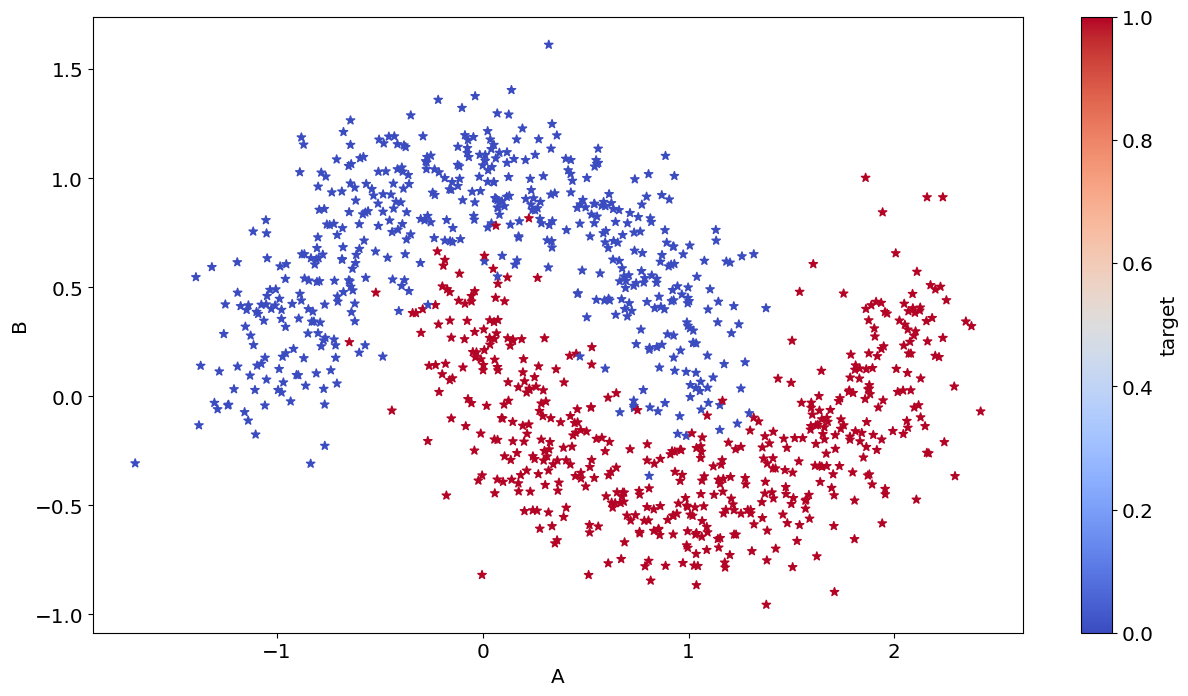

In [9]:
# Plot the data
data_df.plot.scatter('A', 'B',      # columns to plot
                     s = 40,        # size of the marker
                     marker = '*',  # type of marker
                     c = 'target',  # color as per target column
                     cmap=CMAP);    # using colormap

### Activation function

In [10]:
def fn_activ(z):
    return np.tanh(z)

def fn_activ_prime(a):
    return 1. - np.tanh(a)**2
#sigmoid function
def fn_sigmoid(z):
    return 1/ (1+np.exp(-z))

def fn_softmax(z):
    '''
    Args: 
        z : a matrix of z values of shape(m, n_output)
    returns:
        softmax values of z
    '''
    exp_z = np.exp(z)
    return exp_z/np.sum(exp_z, axis=1, keepdims=True)

In [11]:
sm = fn_softmax(np.array([[8, 5, 0], [-10, 0, 10]]))
sm.sum(axis=1, keepdims=True).shape

(2, 1)

### Train Data


In [12]:
X_train,X_test,y_train,y_test=train_test_split(X,y,
                                               stratify=y,
                                               test_size=TEST_SIZE,
                                               random_state=RANDOM_STATE)

In [13]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((800, 2), (200, 2), (800,), (200,))

### Prediction

In [14]:
def predict (model, X_p):

    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']

    # Layer1
    z1 = X_p.dot(W1) + b1 # Aggregation
    a1 = fn_activ(z1) # Activation

    # Layer 2
    z2 = a1.dot(W2) +b2 # Aggregation
    a2 = fn_sigmoid(z2) # Activation
    
    return a2 >= 0.5 # Is it greater or equal to 0.5


### Calculate Loss

In [15]:
def calculate_loss (model, X_l, y_l):

    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']

    m = X_l.shape[0]
    
    # Layer1
    z1 = X_l.dot(W1) + b1 # Aggregation
    a1 = fn_activ(z1) # Activation

    # Layer 2
    z2 = a1.dot(W2) +b2 # Aggregation
    a2 = fn_sigmoid(z2) # Activation

    data_loss = -(y_l*np.log(a2)).sum() # Binary
    
    return data_loss / m

In [16]:
def calculate_loss_multiclass(model, X_l, y_l):
    
    W1, b1, W2, b2= model['W1'], model['b1'], model['W2'], model['b2']  
    
    m = X_l.shape[0]
      
    ### Forward Propagation
    
    ## Layer 1
    
    z1 = X_l.dot(W1) + b1  # Aggregation
    a1 = fn_activ(z1) # Activation
    
    ## Layer 2
    z2 = a1.dot(W2) + b2  # Aggregation
    a2 = fn_softmax(z2)  # Activation
    
    data_loss = - (y_l * np.log(a2) + (1.0 - y_l) * np.log(1.0 - a2)).sum() # Multiclass (# class = 2) loss function
    
    return data_loss / m

### Model Building

In [17]:
loss_hist = {}

In [18]:
def build_model(X_tr, y_tr, 
                nn_hdim, nn_out, 
                alpha=ALPHA, epochs = EPOCHS):
    '''
    Args:
        X_tr : Training features
        y_tr : Training labels
        nn_hdim : number of nodes in the hidden layer
        nn_out : size of output
    '''
    m, nn_input_dim = X_tr.shape
    nn_output_dim = nn_out

    W1 = rng.random((nn_input_dim, nn_hdim), 
             dtype = np.float32) / np.sqrt(nn_input_dim)
    
    W2 = rng.random((nn_hdim, nn_output_dim), 
             dtype = np.float32) / np.sqrt(nn_hdim)
    
    b1 = np.zeros((1, nn_hdim), dtype = np.float32)
    b2 = np.zeros((1, nn_output_dim), dtype = np.float32)

    curr_loss = 0

    loss, epoch = [], []

    for i in range (0, epochs):

        ### Forward Propagation

        # Layer1
        z1 = X_tr.dot(W1) + b1
        a1 = fn_activ(z1)

        # Layer 2
        z2 = a1.dot(W2) +b2 
        a2 = fn_sigmoid(z2)

        ### Back propagation

        assert (a2.shape == y_tr.shape), f'check y {a2.shape}/{y_tr.shape}'
        dz2 = a2 - y_tr ## REMEMBER dim of a2 and y to be same

        dW2 = (a1.T).dot(dz2)
        assert (W2.shape == dW2.shape), f'check W2 {W2.shape}/{dW2.shape}'

        db2 = np.sum(dz2, axis = 0, keepdims=True)
        assert (b2.shape == db2.shape), f'check b2 {b2.shape}/{db2.shape}'

        da1 = dz2.dot(W2.T)
        assert (a1.shape == da1.shape), f'check b2 {a1.shape}/{da1.shape}'

        # Layer 1
        dz1 = da1 * fn_activ_prime(z1)
        assert (z1.shape == dz1.shape), f'check b2 {z1.shape}/{dz1.shape}'

        dW1 = (X_tr.T).dot(dz1)
        assert (W1.shape == dW1.shape), f'check W2 {W1.shape}/{dW1.shape}'

        db1 = np.sum(dz1, axis = 0, keepdims=True)
        assert (b1.shape == db1.shape), f'check b2 {b1.shape}/{db1.shape}'

        ### Gradient Update
        W1 += -alpha * dW1 / m
        b1 += -alpha * db1 / m
        W2 += -alpha * dW2 / m
        b2 += -alpha * db2 / m

        model = {'W1' : W1, 'b1' : b1,
                 'W2' : W2, 'b2' : b2
                 }
        
        curr_loss = calculate_loss(model, X_tr, y_tr)
        loss.append(curr_loss)
        epoch.append(i)

        if i%1000 == 0:
            print (f'After epoch:{i:3d}; loss : {curr_loss: .5f}')

    loss_hist['epoch'] = epoch
    loss_hist['loss'] = loss
    
    return model

In [19]:
# dimenstion check before model training
print(y.shape)
y_t = y.reshape(-1,1)
print(y_t.shape)
nn_out_dim = y_t.shape[1]
print(X.shape)
print(f" nn_out_dim : {nn_out_dim} ")

(1000,)
(1000, 1)
(1000, 2)
 nn_out_dim : 1 


In [20]:
print (y_train.shape)
y_train = y_train.reshape(-1,1)
print (y_train.shape)

(800,)
(800, 1)


In [21]:
nn_out_dim = 1

model = build_model(X_train, y_train, 4, nn_out_dim)

After epoch:  0; loss :  0.29173


<Axes: xlabel='epoch'>

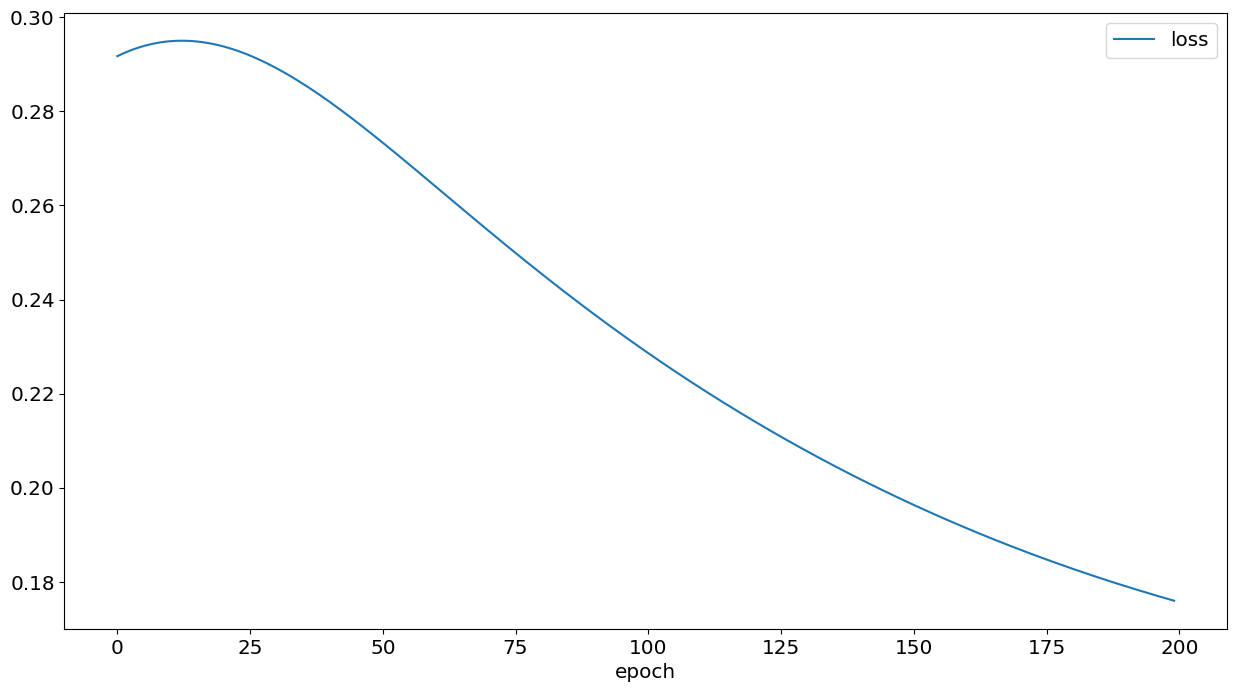

In [22]:
pd.DataFrame(loss_hist).plot(x='epoch')

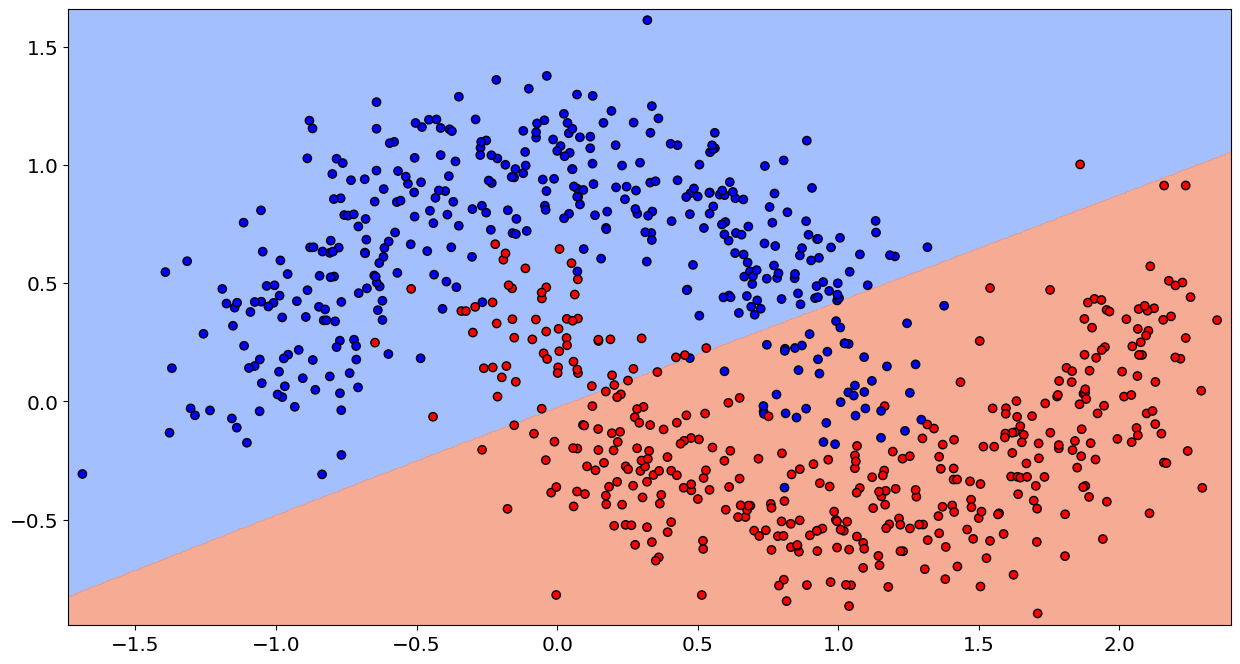

In [23]:
X = X_train
fig, ax = plt.subplots() # instantiation of plt objects
dm = 0.005 # spacing of the grid
x_min, x_max = X[:, 0].min() - 0.05 ,X[:, 0].max() + 0.05
y_min, y_max = X[:, 1].min() - 0.05 ,X[:, 1].max() + 0.05
xx,yy = np.meshgrid(np.arange(x_min, x_max, dm), 
                    np.arange(y_min, y_max, dm)) # generate a mesh
XX = np.c_[xx.ravel(), yy.ravel()] # prepare feature data

y_pred = predict(model, XX)

Z = np.array(y_pred).reshape(xx.shape)

ax.contourf(xx,yy, Z, cmap=CMAP, alpha = 0.8)

ax.scatter(X[:, 0], X[:, 1], c = y_train, 
           edgecolors='k', 
           cmap = plt.cm.bwr)

Accuracy

In [24]:
y_pred= predict(model, X_train)
accuracy_score(y_train,y_pred)

0.86625

In [25]:
y_pred= predict(model, X_test)
accuracy_score(y_test,y_pred)

0.845

In [26]:
cm=confusion_matrix(y_test, y_pred)
cm

array([[87, 13],
       [18, 82]], dtype=int64)

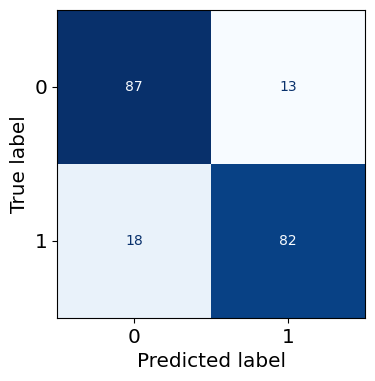

In [27]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
fig,ax=plt.subplots(figsize=(4,4))

disp.plot(ax= ax, cmap='Blues', colorbar=False);
ax.grid(False);